## 1. <font color = red> Install and Import the Required Libraries

In [1]:
# Install all the required libraries

!pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers

In [11]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb
import re

In [ ]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [1]:
# Define the path of the PDF
# single_pdf_path = '/content/drive/MyDrive/Policy Documents/Principal-Sample-Life-Insurance-Policy.pdf'
single_pdf_path = 'Policy Documents/Principal-Sample-Life-Insurance-Policy.pdf'

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [7]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[55]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

If a Member sustains an injury, and as a result of such injury, one or more of the covered losses
listed below are incurred, The Principal will pay the following percentages of the Member's
Scheduled Benefit (or approved amount, if applicable) in force, provided all Benefit
Qualifications as described in Article 2 are met.
% of Scheduled
Covered Loss Benefit
Loss of Use or Paralysis
Quadriplegia 100%
Paraplegia 50%
Hemiplegia 50%
Both Hands or Both Feet 50%
One Hand and One Foot 50%
One Arm or One Leg 25%
One Hand or One Foot 25%
The Principal does not pay an Accidental Death and Dismemberment benefit for any paralysis
caused by a stroke.
Paralysis must be determined by a Physician to be permanent, complete, and irreversible.
Total payment for all losses that result from the same accident will not exceed the Scheduled
Benefit (or approved amount, if applicable). Payment for Loss will be to the Member.
For this benefit, the term "Loss of Use" means a total and irrevocable loss of volunt

In [9]:
# View the table in the page, if any

tables[0]

IndexError: list index out of range

#### <font color = red> 2.2 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [499]:
# Define the path where all pdf documents are present

# pdf_path = "/content/drive/My Drive/Policy Documents"
pdf_path = "Policy Documents"

In [13]:
# Function to clean extracted text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.strip()  # Remove leading/trailing whitespace
    return text

In [489]:
# Function to extract text with metadata and preprocess it
def extract_text_with_metadata(pdf_path, chunk_size=500, overlap=50):
    data = []
    # part, section, article = None, None, None
    part, section, article = "Not Applicable", "Not Applicable", "Not Applicable"
    footnote_marker = "This policy has been updated"  # Line starting with this pattern denotes that footnote commenced
    
    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages, start=1):    # Loop to process the Page Content
            text = page.extract_text()
            if not text:
                continue  # Skip empty pages
            footnote_flag = 0
            
            lines = text.split("\n")
            current_text = ""

            for line_num, line in enumerate(lines):      # Loop to process a line in the Page
                line = clean_text(line)  # Apply text cleaning
                # if line_num == 0:
                #     print('Page: ' + str(page_num) + ' Line 0: ' + line)
                
                # Skip headers and footers based on known patterns
                # if re.search(r"(Page \d+|Confidential|Policy Number|Insurance Terms)", line, re.IGNORECASE):
                if re.match(r"^{}".format(footnote_marker), line, re.IGNORECASE):
                    footnote_flag = 1
                if footnote_flag:
                    continue
                
                # Detect Part Titles
                if re.match(r"^(PART|P\s+ART)\b\s+[IVXLCDM]+", line, re.IGNORECASE) or \
                re.match(r"^TABLE OF CONTENTS", line, re.IGNORECASE):
                    # print('Page: ' + str(page_num) + ' Line Num: ' + str(line_num) + ' Text: ' + line)
                    # print('Next Line Num: ' + str(line_num+1) + ' Text: ' + lines[line_num+1])
                    if line_num == 0:
                        part = line
                        continue
                    else:        # It's PART line in footer
                        continue

                if part == 'TABLE OF CONTENTS':    # Ignore TOC lines
                    continue
                
                # Detect Section Titles
                elif re.match(r"^Section\s+[A-Z]\s*-\s+.*", line, re.IGNORECASE):
                    section = line
                
                # Detect Article Titles (Retain Article Numbers)
                elif re.match(r"^ARTICLE\s+\d+\s*-\s+.*", line, re.IGNORECASE):
                    if current_text:
                        # Store previous chunk before resetting
                        chunked_texts = chunk_text(current_text, chunk_size, overlap)
                        for chunk in chunked_texts:
                            data.append([part, section, article, page_num, chunk, len(chunk.split())])
                        current_text = ""
                        
                    article = line    # Reset the article

                # Append regular text
                else:
                    current_text += " " + line

            # Save remaining text on page
            if current_text:
                chunked_texts = chunk_text(current_text, chunk_size, overlap)
                for chunk in chunked_texts:
                    data.append([part, section, article, page_num, chunk, len(chunk.split())])
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["Part", "Section", "Article", "Page Number", "Chunk Text", "Chunk Length"])
    return df

In [21]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')  # Download sentence tokenizer

[nltk_data] Downloading package punkt to /Users/achindas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [319]:
# Function to chunk large text with overlap
def chunk_text(text, chunk_size=500, overlap=50):
    sentences = sent_tokenize(text)
    # print("Sentence Count: " + str(len(sentences)))
    # print("1st Sent: " + sentences[0])
    # if len(sentences) > 1: print ("2nd Sent: " + sentences[1])
    
    chunks = []
    current_chunk = ""
    
    for sentence in sentences:
        if len(current_chunk.split()) + len(sentence.split()) < chunk_size:
            current_chunk += " " + sentence
        else:
            chunks.append(current_chunk.strip())
            current_chunk = " ".join(current_chunk.split()[-overlap:]) if overlap > 0 else "" + sentence  # Keep overlap                    
    
    if current_chunk:
        chunks.append(current_chunk.strip())
    
    return chunks

In [409]:
# PDF file name with path
pdf_file_w_path = "Policy Documents/Principal-Sample-Life-Insurance-Policy.pdf"

# Extract text and store in DataFrame
df_chunks = extract_text_with_metadata(pdf_file_w_path)

# Display first 5 rows
df_chunks.head()

,Part,Section,Article,Page Number,Chunk Text,Chunk Length
0,None,None,None,1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014,30
1,None,None,None,2,This page left blank intentionally,5
2,None,None,None,3,"POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the provision of such goods and/or services nor is it liable for the failure of the provision of the same. Further, The Principal is not liable to the applicants/insureds/enrollees for the negligent provision of such goods and/or services by the third party service providers. EXCEPT AS SPECIFICALLY DESCRIBED IN THIS RIDER, ALL OTHER BENEFITS AND PROVISIONS WILL BE AS DESCRIBED IN THE GROUP POLICY. PRINCIPAL LIFE INSURANCE COMPANY DES MOINES, IOWA 50392-0001 GC 806 VAL",230
3,None,None,None,4,This page left blank intentionally,5
4,None,None,None,5,"PRINCIPAL LIFE INSURANCE COMPANY (called The Principal in this Group Policy) Des Moines, Iowa 50392-0002 This group insurance policy is issued to: RHODE ISLAND JOHN DOE (called the Policyholder in this Group Policy) The Date of Issue is November 1, 2007. In return for the Policyholder's application and payment of all premiums when due, The Principal agrees to provide: MEMBER LIFE INSURANCE MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE DEPENDENT LIFE INSURANCE subject to the terms and conditions described in this Group Policy. GROUP POLICY NO. GL S655 RENEWABLE TERM - NON-PARTICIPATING CONTRACT STATE OF ISSUE: RHODE ISLAND",97


In [719]:
# Set the max_colwidth option to display full column content
pd.set_option('display.max_colwidth', None)

In [413]:
df_chunks[df_chunks['Page Number'].isin(range(53, 56))]

,Part,Section,Article,Page Number,Chunk Text,Chunk Length
82,PART IV - BENEFITS,Section B - Member Accidental Death and Dismemberment Insurance,Article 1 - Schedule of Insurance,53,"Subject to the Effective Date provisions of PART III, Section B, and the qualifying provisions of this Section B, the Scheduled Benefit for an insured Member will be based on his or her class: Class *Scheduled Benefit ALL MEMBERS $10,000 *The Scheduled Benefit is subject to the Proof of Good Health requirements as shown in PART III, Section B, Article 1. Because of the Proof of Good Health requirements, the amount of insurance approved by The Principal may be different than the Scheduled Benefit. If the approved amount of insurance is different than the Scheduled Benefit, the approved amount will apply. For the age(s) shown below, the amount of a Member's insurance will be the percentage of the Scheduled Benefit (or approved amount, if applicable) as shown below. Age % of Scheduled Benefit (or approved amount, whichever applies) Age 70 but less than age 75 65% Age 75 and over 45%",151
83,PART IV - BENEFITS,Section B - Member Accidental Death and Dismemberment Insurance,Article 2 - Benefit Qualification,53,"To qualify for benefit payment, all of the following must occur: a. the Member must be injured while insured for Member Accidental Death and Dismemberment Insurance under this Group Policy; and b. the injury must be through external, violent, and accidental means; and c. the injury must be the direct and sole cause of a loss listed in this Section B, Article 3; and d. the loss must occur within 365 days of the injury; and e. the limitations listed in this Section B, Article 9, must not apply; and",90
84,PART IV - BENEFITS,Section B - Member Accidental Death and Dismemberment Insurance,Article 2 - Benefit Qualification,54,"f . claim requirements listed in PART IV, Section D, must be satisfied; and g. all medical evidence must be satisfactory to The Principal.",24
85,PART IV - BENEFITS,Section B - Member Accidental Death and Dismemberment Insurance,Article 3 - Benefits Payable,54,"If all of the benefit qualifications are met, The Principal will pay: a. 100% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of life; or b. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one hand is severed at or above the wrist; or c. 25% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of thumb and index finger on the same hand; or d. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one foot is severed at or above the ankle; or e. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if the sight of one eye is permanently lost (For this purpose, vision not correctable to better than 20/200 will be considered loss of sight. ); or f. 100% of the Scheduled Benefit (or approved amount, if applicable) in force for more than one of the losses listed in b., d., or e. above. Total payment for all losses under this Article 3 that result from the same accident will not exceed the Scheduled Benefit (or approved amount, if applicable). Payment for loss of life will be to the beneficiary named for Member Life Insurance. Payment will be subject to the Beneficiary, Facility of Payment and Settlement of Proceeds provisions of PART IV, Section A. Payment for all other losses will be to the Member. Disappearance It will be presumed that a Member has lost his or her life if: a. the Member's body has not been found within 365 days after the disappearance of a conveyance in which the Member was an occupant at the time of disappearance; and b. the disappearance of the conveyance was due to its accidental wrecking or sinking; and c. this Group Policy would have covered the injury resulting from the accident.",314
86,PART IV - BENEFITS,Section B - Member Accidental Death and Dismemberment Insurance,Article 3 - Benefits Payable,55,"Exposure Exposure to the 

In [405]:
df_chunks[['Article']].value_counts()

Article                                                                             
Article 1 - Member Life Insurance                                                       70
Article 3 - Dependent Life Insurance                                                    21
Article 6 - Member Life Insurance - Coverage During Disability                          20
Article 1 - Schedule of Insurance                                                       14
Article 2 - Dependent Life Insurance                                                    12
Article 2 - Death Benefits Payable                                                       9
Article 7 - Accelerated Benefits                                                         9
Article 3 - Benefits Payable                                                             8
Article 3 - Beneficiary                                                                  7
Article 4 - Payment, Denial, and Review                                                  7
Artic

In [441]:
# Reset to default settings
pd.reset_option('display.max_colwidth')

In [17]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [19]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [503]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text and metadata from the PDF and store in DataFrame
    # extracted_text_df = extract_text_from_pdf(pdf_path)
    extracted_text_df = extract_text_with_metadata(pdf_path)

    # Add a column to store document names
    # extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [507]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [509]:
insurance_pdfs_data

,Part,Section,Article,Page Number,Chunk Text,Chunk Length,Document Name
0,Not Applicable,Not Applicable,Not Applicable,1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,30,Principal-Sample-Life-Insurance-Policy.pdf
1,Not Applicable,Not Applicable,Not Applicable,2,This page left blank intentionally,5,Principal-Sample-Life-Insurance-Policy.pdf
2,Not Applicable,Not Applicable,Not Applicable,3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,230,Principal-Sample-Life-Insurance-Policy.pdf
3,Not Applicable,Not Applicable,Not Applicable,4,This page left blank intentionally,5,Principal-Sample-Life-Insurance-Policy.pdf
4,Not Applicable,Not Applicable,Not Applicable,5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,97,Principal-Sample-Life-Insurance-Policy.pdf
...,...,...,...,...,...,...,...
105,PART IV - BENEFITS,Section D - Claim Procedures,Article 6 - Autopsy,62,"If payment for loss of life is claimed, The Pr...",22,Principal-Sample-Life-Insurance-Policy.pdf
106,PART IV - BENEFITS,Section D - Claim Procedures,Article 7 - Legal Action,62,Legal action to recover benefits under this Gr...,52,Principal-Sample-Life-Insurance-Policy.pdf
107,PART IV - BENEFITS,Section D - Claim Procedures,Article 8 - Time Limits,62,Any time limits in this section will be adjust...,13,Principal-Sample-Life-Insurance-Policy.pdf
108,PART IV - BENEFITS,Section D - Claim Procedures,Article 8 - Time Limits,63,This page left blank intentionally,5,Principal-Sample-Life-Insurance-Policy.pdf


In [511]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data['Chunk Text'][2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [29]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

# insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [457]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Chunk Length']

0       30
2      230
4       97
5      365
6      234
      ... 
103    153
104     41
105     22
106     52
107     13
Name: Chunk Length, Length: 105, dtype: int64

In [513]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Chunk Length'] >= 10]
insurance_pdfs_data

,Part,Section,Article,Page Number,Chunk Text,Chunk Length,Document Name
0,Not Applicable,Not Applicable,Not Applicable,1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,30,Principal-Sample-Life-Insurance-Policy.pdf
2,Not Applicable,Not Applicable,Not Applicable,3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,230,Principal-Sample-Life-Insurance-Policy.pdf
4,Not Applicable,Not Applicable,Not Applicable,5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,97,Principal-Sample-Life-Insurance-Policy.pdf
5,P ART I - DEFINITIONS,Not Applicable,Not Applicable,9,When used in this Group Policy the terms liste...,365,Principal-Sample-Life-Insurance-Policy.pdf
6,P ART I - DEFINITIONS,Not Applicable,Not Applicable,10,T he legally recognized union of two eligible ...,234,Principal-Sample-Life-Insurance-Policy.pdf
...,...,...,...,...,...,...,...
103,PART IV - BENEFITS,Section D - Claim Procedures,"Article 4 - Payment, Denial, and Review",62,A claimant may request an appeal of a claim de...,153,Principal-Sample-Life-Insurance-Policy.pdf
104,PART IV - BENEFITS,Section D - Claim Procedures,Article 5 - Medical Examinations,62,The Principal may have the Member or Dependent...,41,Principal-Sample-Life-Insurance-Policy.pdf
105,PART IV - BENEFITS,Section D - Claim Procedures,Article 6 - Autopsy,62,"If payment for loss of life is claimed, The Pr...",22,Principal-Sample-Life-Insurance-Policy.pdf
106,PART IV - BENEFITS,Section D - Claim Procedures,Article 7 - Legal Action,62,Legal action to recover benefits under this Gr...,52,Principal-Sample-Life-Insurance-Policy.pdf


In [515]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], \
                                                                       'Page_No.': x['Page Number'], 'Part': x['Part'], \
                                                                       'Section': x['Section'], 'Article': x['Article']
                                                                      }, axis=1)

/var/folders/5v/crs6n92910z21q7d7kcnrplh0000gn/T/ipykernel_5539/1782543228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], \


In [517]:
insurance_pdfs_data

,Part,Section,Article,Page Number,Chunk Text,Chunk Length,Document Name,Metadata
0,Not Applicable,Not Applicable,Not Applicable,1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,30,Principal-Sample-Life-Insurance-Policy.pdf,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Not Applicable,Not Applicable,Not Applicable,3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,230,Principal-Sample-Life-Insurance-Policy.pdf,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Not Applicable,Not Applicable,Not Applicable,5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,97,Principal-Sample-Life-Insurance-Policy.pdf,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,P ART I - DEFINITIONS,Not Applicable,Not Applicable,9,When used in this Group Policy the terms liste...,365,Principal-Sample-Life-Insurance-Policy.pdf,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,P ART I - DEFINITIONS,Not Applicable,Not Applicable,10,T he legally recognized union of two eligible ...,234,Principal-Sample-Life-Insurance-Policy.pdf,{'Policy_Name': 'Principal-Sample-Life-Insuran...
...,...,...,...,...,...,...,...,...
103,PART IV - BENEFITS,Section D - Claim Procedures,"Article 4 - Payment, Denial, and Review",62,A claimant may request an appeal of a claim de...,153,Principal-Sample-Life-Insurance-Policy.pdf,{'Policy_Name': 'Principal-Sample-Life-Insuran...
104,PART IV - BENEFITS,Section D - Claim Procedures,Article 5 - Medical Examinations,62,The Principal may have the Member or Dependent...,41,Principal-Sample-Life-Insurance-Policy.pdf,{'Policy_Name': 'Principal-Sample-Life-Insuran...
105,PART IV - BENEFITS,Section D - Claim Procedures,Article 6 - Autopsy,62,"If payment for loss of life is claimed, The Pr...",22,Principal-Sample-Life-Insurance-Policy.pdf,{'Policy_Name': 'Principal-Sample-Life-Insuran...
106,PART IV - BENEFITS,Section D - Claim Procedures,Article 7 - Legal Action,62,Legal action to recover benefits under this Gr...,52,Principal-Sample-Life-Insurance-Policy.pdf,{'Policy_Name': 'Principal-Sample-Life-Insuran...


In [527]:
insurance_pdfs_data['Metadata'][2]

{'Policy_Name': 'Principal-Sample-Life-Insurance-Policy',
 'Page_No.': 3,
 'Part': 'Not Applicable',
 'Section': 'Not Applicable',
 'Article': 'Not Applicable'}

This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [469]:
# Set the API key
# filepath = "/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/"
filepath = ""

with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [471]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [473]:
# Define the path where chroma collections will be stored

# chroma_data_path = '/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/Week 3/ChromaDB_Data'
chroma_data_path = 'ChromaDB_Data'

In [475]:
import chromadb

In [477]:
# Call PersistentClient()

client = chromadb.PersistentClient(path=chroma_data_path)

In [479]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [481]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [529]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Chunk Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [531]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [533]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-2.25940198e-02,  1.86782442e-02, -2.72537917e-02, ...,
         -3.69388051e-02,  2.90256785e-03, -1.38683687e-03],
        [-1.32057490e-02,  8.82212631e-03, -4.67860838e-03, ...,
         -1.56548154e-02, -4.84764605e-05,  7.25115696e-03],
        [-1.04612475e-02,  1.23801352e-02, -6.33977412e-04, ...,
         -2.45352983e-02, -1.54040381e-02,  9.60105658e-03]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Gri

In [535]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [861]:
cache_collection.peek()

{'ids': ['What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?',
  'How often the proof of disability to be sent to the Principal for coverage during disability?',
  'What are the dependent rights under the Group Policy?'],
 'embeddings': array([[ 0.00951563,  0.00153726,  0.01812631, ..., -0.0138311 ,
         -0.01102166, -0.01273029],
        [ 0.01931848,  0.00685622,  0.00857356, ...,  0.0067641 ,
         -0.00132255, -0.01688393],
        [ 0.00424775,  0.00388002,  0.01026195, ..., -0.01413166,
          0.00120456,  0.00941652]]),
 'documents': ['What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?',
  'How often the proof of disability to be sent to the Principal for coverage during disability?',
  'What are the dependent rights under the Group Policy?'],
 'uris': None,
 'data': None,
 'metadatas': [{'distances0': '0.25901901721954346',
   'distances1': '0.2593732476234436',
  

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [808]:
# Read the user query

query = input()

 What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?


In [810]:
query

'What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?'

In [780]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [781]:
cache_results

{'ids': [['How often the proof of disability to be sent to the Principal for coverage during disability?']],
 'embeddings': None,
 'documents': [['How often the proof of disability to be sent to the Principal for coverage during disability?']],
 'uris': None,
 'data': None,
 'metadatas': [[{'distances0': '0.24966901540756226',
    'distances1': '0.27747926115989685',
    'distances2': '0.2793901860713959',
    'distances3': '0.28407225012779236',
    'distances4': '0.2922617197036743',
    'distances5': '0.30131277441978455',
    'distances6': '0.3067398785651384',
    'distances7': '0.3098026216030121',
    'distances8': '0.32754064238649144',
    'distances9': '0.3345561921596527',
    'documents0': 'Written proof of loss must be sent to The Principal within 90 days after the date of the loss. Proof required includes the date, nature, and extent of the loss. The Principal may request additional information to substantiate loss or require a Signed unaltered authorization to obtain tha

In [735]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)

In [743]:
results.get('documents')[0][2]

"Coverage During Disability will cease on the earliest of: (1) the date the Member's Total Disability ends; or (2) the date the Member fails to send The Principal any required proof of ADL Disability or Total Disability; or (3) the date the Member ceases to be under the regular care and attendance of a Physician; or (4) the date the Member fails to submit to a required Medical Examination or Evaluation; or (5) the date the Member attains age 70. g. Limitations No benefits will be paid for any disability that: (1) results from willful self-injury or self-destruction, while sane or insane; or (2) results from war or act of war; or (3) results from voluntary participation in an assault, felony, criminal activity, insurrection, or riot."

In [812]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        print('Key: ', key)
        print ('Value: ', val)
        if val is None or key == 'included':
          continue
        for i in range(10):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Key:  ids
Value:  [['84', '80', '82', '37', '45', '83', '77', '88', '89', '74']]
Key:  embeddings
Value:  None
Key:  documents
Value:  [['If the Member loses his or her life as a result of an accidental injury sustained while driving or riding in an Automobile, an additional benefit of $10,000 will be paid to the beneficiary named for Member Life Insurance, provided all Benefit Qualifications as described in Article 2 are met and: a. the Automobile is equipped with factory-installed Seat Belts; and b. the Seat Belt was in actual use by the Member and properly fastened at the time of the accident; and c. the position of the Seat Belt is certified in the official report of the accident or by the investigating officer. This additional benefit payment will also apply if the Member was driving an Automobile equipped with a properly functioning driver-side air bag or riding as a passenger in an Automobile equipped with a properly functioning passenger-side air bag, although the Member\'s Sea

Add of existing embedding ID: What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?
Insert of existing embedding ID: What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?


Not found in cache. Found in main collection.


In [814]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Article': 'Article 4 - Seat Belt/Airbag Benefit', 'Page_No.': 55, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}","If the Member loses his or her life as a result of an accidental injury sustained while driving or riding in an Automobile, an additional benefit of $10,000 will be paid to the beneficiary named for Member Life Insurance, provided all Benefit Qualifications as described in Article 2 are met and: a. the Automobile is equipped with factory-installed Seat Belts; and b. the Seat Belt was in actual use by the Member and properly fastened at the time of the accident; and c. the position of the Seat Belt is certified in the official report of the accident or by the investigating officer. This additional benefit payment will also apply if the Member was driving an Automobile equipped with a properly functioning driver-side air bag or riding as a passenger in an Automobile equipped with a properly functioning passenger-side air bag, although the Member's Seat Belt may not have been fastened at the time of the accident. The properly functioning and/or deployment of the air bag must be certified in the official report of the accident or by the investigating officer. For the purpose of this benefit, ""Automobile"" means a four-wheel passenger vehicle, station wagon, pick-up truck, or van-type vehicle, but excludes recreational-type vehicles such as a ""dune-buggy"" or an ""all-terrain"" vehicle. The term ""Seat Belt"" means a factory-installed device that forms an occupant restraint and injury avoidance system.",0.259019,84
1,"{'Article': 'Article 2 - Benefit Qualification', 'Page_No.': 53, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}","To qualify for benefit payment, all of the following must occur: a. the Member must be injured while insured for Member Accidental Death and Dismemberment Insurance under this Group Policy; and b. the injury must be through external, violent, and accidental means; and c. the injury must be the direct and sole cause of a loss listed in this Section B, Article 3; and d. the loss must occur within 365 days of the injury; and e. the limitations listed in this Section B, Article 9, must not apply; and",0.259373,80
2,"{'Article': 'Article 3 - Benefits Payable', 'Page_No.': 54, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}","If all of the benefit qualifications are met, The Principal will pay: a. 100% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of life; or b. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one hand is severed at or above the wrist; or c. 25% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of thumb and index finger on the same hand; or d. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one foot is severed at or above the ankle; or e. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if the sight of one eye is permanently lost (For this purpose, vision not correctable to better than 20/200 will be considered loss of sight. ); or f. 100% of the Scheduled Benefit (or approved amount, if applicable) in force for more than one of the losses listed in b., d., or e. above. Total payment for all losses under this Article 3 that result from the same accident will not exceed the Scheduled Benefit (or approved amount, if applicable). Payment for loss of life will be to the beneficiary named for Member Life Insurance. Payment will be subject to the Beneficiary, Facility of Payment and Settlement of Proceeds provisions of PART IV, Section A. Payment for all other

## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

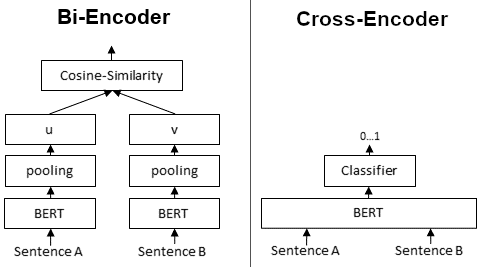

<br>

In [563]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [564]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [567]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [568]:
scores

array([  3.846764, -11.25288 ], dtype=float32)

In [816]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [818]:
cross_rerank_scores

array([ 4.627643  ,  4.3196907 ,  1.3528196 ,  1.8726966 , -2.7761202 ,
       -5.0299187 , -7.7980022 , -4.604636  , -6.5996814 , -0.92883354],
      dtype=float32)

In [820]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [822]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Article': 'Article 4 - Seat Belt/Airbag Benefit', 'Page_No.': 55, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}","If the Member loses his or her life as a result of an accidental injury sustained while driving or riding in an Automobile, an additional benefit of $10,000 will be paid to the beneficiary named for Member Life Insurance, provided all Benefit Qualifications as described in Article 2 are met and: a. the Automobile is equipped with factory-installed Seat Belts; and b. the Seat Belt was in actual use by the Member and properly fastened at the time of the accident; and c. the position of the Seat Belt is certified in the official report of the accident or by the investigating officer. This additional benefit payment will also apply if the Member was driving an Automobile equipped with a properly functioning driver-side air bag or riding as a passenger in an Automobile equipped with a properly functioning passenger-side air bag, although the Member's Seat Belt may not have been fastened at the time of the accident. The properly functioning and/or deployment of the air bag must be certified in the official report of the accident or by the investigating officer. For the purpose of this benefit, ""Automobile"" means a four-wheel passenger vehicle, station wagon, pick-up truck, or van-type vehicle, but excludes recreational-type vehicles such as a ""dune-buggy"" or an ""all-terrain"" vehicle. The term ""Seat Belt"" means a factory-installed device that forms an occupant restraint and injury avoidance system.",0.259019,84,4.627643
1,"{'Article': 'Article 2 - Benefit Qualification', 'Page_No.': 53, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}","To qualify for benefit payment, all of the following must occur: a. the Member must be injured while insured for Member Accidental Death and Dismemberment Insurance under this Group Policy; and b. the injury must be through external, violent, and accidental means; and c. the injury must be the direct and sole cause of a loss listed in this Section B, Article 3; and d. the loss must occur within 365 days of the injury; and e. the limitations listed in this Section B, Article 9, must not apply; and",0.259373,80,4.319691
2,"{'Article': 'Article 3 - Benefits Payable', 'Page_No.': 54, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}","If all of the benefit qualifications are met, The Principal will pay: a. 100% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of life; or b. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one hand is severed at or above the wrist; or c. 25% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of thumb and index finger on the same hand; or d. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one foot is severed at or above the ankle; or e. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if the sight of one eye is permanently lost (For this purpose, vision not correctable to better than 20/200 will be considered loss of sight. ); or f. 100% of the Scheduled Benefit (or approved amount, if applicable) in force for more than one of the losses listed in b., d., or e. above. Total payment for all losses under this Article 3 that result from the same accident will not exceed the Scheduled Benefit (or approved amount, if applicable). Payment for loss of life will be to the beneficiary named for Member Life Insurance. Payment will be subject to the Beneficiary, Facility of Payment and Settlement of Proceeds provisions of PART IV

In [614]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,84,If the Member loses his or her life as a resul...,0.25901901721954346,{'Article': 'Article 4 - Seat Belt/Airbag Bene...,4.627643
1,80,"To qualify for benefit payment, all of the fol...",0.2593732476234436,{'Article': 'Article 2 - Benefit Qualification...,4.319691
2,82,"If all of the benefit qualifications are met, ...",0.28698959946632385,"{'Article': 'Article 3 - Benefits Payable', 'P...",1.352820


In [824]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Article': 'Article 4 - Seat Belt/Airbag Benefit', 'Page_No.': 55, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}","If the Member loses his or her life as a result of an accidental injury sustained while driving or riding in an Automobile, an additional benefit of $10,000 will be paid to the beneficiary named for Member Life Insurance, provided all Benefit Qualifications as described in Article 2 are met and: a. the Automobile is equipped with factory-installed Seat Belts; and b. the Seat Belt was in actual use by the Member and properly fastened at the time of the accident; and c. the position of the Seat Belt is certified in the official report of the accident or by the investigating officer. This additional benefit payment will also apply if the Member was driving an Automobile equipped with a properly functioning driver-side air bag or riding as a passenger in an Automobile equipped with a properly functioning passenger-side air bag, although the Member's Seat Belt may not have been fastened at the time of the accident. The properly functioning and/or deployment of the air bag must be certified in the official report of the accident or by the investigating officer. For the purpose of this benefit, ""Automobile"" means a four-wheel passenger vehicle, station wagon, pick-up truck, or van-type vehicle, but excludes recreational-type vehicles such as a ""dune-buggy"" or an ""all-terrain"" vehicle. The term ""Seat Belt"" means a factory-installed device that forms an occupant restraint and injury avoidance system.",0.259019,84,4.627643
1,"{'Article': 'Article 2 - Benefit Qualification', 'Page_No.': 53, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}","To qualify for benefit payment, all of the following must occur: a. the Member must be injured while insured for Member Accidental Death and Dismemberment Insurance under this Group Policy; and b. the injury must be through external, violent, and accidental means; and c. the injury must be the direct and sole cause of a loss listed in this Section B, Article 3; and d. the loss must occur within 365 days of the injury; and e. the limitations listed in this Section B, Article 9, must not apply; and",0.259373,80,4.319691
3,"{'Article': 'Article 2 - Member Accidental Death and Dismemberment Insurance', 'Page_No.': 26, 'Part': 'PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section A - Eligibility'}",A person will be eligible for Member Accidental Death and Dismemberment Insurance on the latest of: a. the date the person is eligible for Member Life Insurance; or b. the date the person enters a class for which Member Accidental Death and Dismemberment Insurance is provided under this Group Policy; or c. the date Member Accidental Death and Dismemberment Insurance is added to this Group Policy.,0.307331,37,1.872697


In [826]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [828]:
top_3_RAG

,Documents,Metadatas
0,"If the Member loses his or her life as a result of an accidental injury sustained while driving or riding in an Automobile, an additional benefit of $10,000 will be paid to the beneficiary named for Member Life Insurance, provided all Benefit Qualifications as described in Article 2 are met and: a. the Automobile is equipped with factory-installed Seat Belts; and b. the Seat Belt was in actual use by the Member and properly fastened at the time of the accident; and c. the position of the Seat Belt is certified in the official report of the accident or by the investigating officer. This additional benefit payment will also apply if the Member was driving an Automobile equipped with a properly functioning driver-side air bag or riding as a passenger in an Automobile equipped with a properly functioning passenger-side air bag, although the Member's Seat Belt may not have been fastened at the time of the accident. The properly functioning and/or deployment of the air bag must be certified in the official report of the accident or by the investigating officer. For the purpose of this benefit, ""Automobile"" means a four-wheel passenger vehicle, station wagon, pick-up truck, or van-type vehicle, but excludes recreational-type vehicles such as a ""dune-buggy"" or an ""all-terrain"" vehicle. The term ""Seat Belt"" means a factory-installed device that forms an occupant restraint and injury avoidance system.","{'Article': 'Article 4 - Seat Belt/Airbag Benefit', 'Page_No.': 55, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}"
1,"To qualify for benefit payment, all of the following must occur: a. the Member must be injured while insured for Member Accidental Death and Dismemberment Insurance under this Group Policy; and b. the injury must be through external, violent, and accidental means; and c. the injury must be the direct and sole cause of a loss listed in this Section B, Article 3; and d. the loss must occur within 365 days of the injury; and e. the limitations listed in this Section B, Article 9, must not apply; and","{'Article': 'Article 2 - Benefit Qualification', 'Page_No.': 53, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}"
3,A person will be eligible for Member Accidental Death and Dismemberment Insurance on the latest of: a. the date the person is eligible for Member Life Insurance; or b. the date the person enters a class for which Member Accidental Death and Dismemberment Insurance is provided under this Group Policy; or c. the date Member Accidental Death and Dismemberment Insurance is added to this Group Policy.,"{'Article': 'Article 2 - Member Accidental Death and Dismemberment Insurance', 'Page_No.': 26, 'Part': 'PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section A - Eligibility'}"


In [622]:
top_3_RAG['Documents'][0]

'If the Member loses his or her life as a result of an accidental injury sustained while driving or riding in an Automobile, an additional benefit of $10,000 will be paid to the beneficiary named for Member Life Insurance, provided all Benefit Qualifications as described in Article 2 are met and: a. the Automobile is equipped with factory-installed Seat Belts; and b. the Seat Belt was in actual use by the Member and properly fastened at the time of the accident; and c. the position of the Seat Belt is certified in the official report of the accident or by the investigating officer. This additional benefit payment will also apply if the Member was driving an Automobile equipped with a properly functioning driver-side air bag or riding as a passenger in an Automobile equipped with a properly functioning passenger-side air bag, although the Member\'s Seat Belt may not have been fastened at the time of the accident. The properly functioning and/or deployment of the air bag must be certifie

In [723]:
top_3_RAG['Metadatas']

0                  {'Article': 'Article 4 - Seat Belt/Airbag Benefit', 'Page_No.': 55, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}
1                     {'Article': 'Article 2 - Benefit Qualification', 'Page_No.': 53, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}
3    {'Article': 'Article 2 - Member Accidental Death and Dismemberment Insurance', 'Page_No.': 26, 'Part': 'PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section A - Eligibility'}
Name: Metadatas, dtype: object

## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [763]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the list '{top_3_RAG.Documents}'. These search results are essentially extracted from an insurance document that may be relevant to the user query.

                                                The metadatas list '{top_3_RAG.Metadatas}' contains the policy name, page no., part and section. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents list to answer the query '{query}'. Frame an informative answer and also, use the metadata list to return the relevant policy names, page numbers, part numbers and section numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular format.
                                                3. Use the Metadatas to retrieve and cite the Policy_Name, Part, Section and Page_No. as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]    
    response = openai.chat.completions.create(
        # model="gpt-3.5-turbo",
        model="gpt-4o-mini",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [830]:
# Generate the response

response = generate_response(query, top_3_RAG)

### Iteration-1 with following configurations:

* Embedding Model: **text-embedding-ada-002**
* Cross Encoder Model: **ms-marco-MiniLM-L-6-v2**
* LLM Model: **gpt-4o-mini**

In [834]:
# Query-1
query

'What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?'

In [832]:
# Print the response - Query-1

# print("\n".join(response))

To be eligible for accidental benefits when life is lost in an automobile accident, the following criteria must be met:

1. The member must lose their life as a result of an accidental injury sustained while driving or riding in an automobile.
2. The automobile must be equipped with factory-installed seat belts, and the seat belt must have been in actual use and properly fastened at the time of the accident. This must be certified in the official accident report or by the investigating officer.
3. Alternatively, if the member was driving or riding in an automobile equipped with functioning air bags, the benefits may still apply even if the seat belt was not fastened, provided the proper functioning of the air bag is certified in the official report.
4. The benefits are specifically applicable to four-wheel passenger vehicles, station wagons, pickup trucks, or vans, excluding recreational vehicles such as dune buggies or all-terrain vehicles.

Additionally, to qualify for the benefits, 

In [772]:
# Query-2
query

'How often the proof of disability to be sent to the Principal for coverage during disability?'

In [770]:
# Print the response - Query-2

# print("\n".join(response))

To maintain coverage during a disability, proof of ADL (Activities of Daily Living) Disability or Total Disability must be sent to The Principal as follows:

1. **Initial Proof**: Written proof must be submitted within one year from the date the ADL Disability or Total Disability begins.
2. **Ongoing Proof**: Further proof that the disability has not ended must be sent when required by The Principal.
3. **After Two Years**: Once ADL Disability or Total Disability has continued for two years from the date the first proof is received, The Principal may only request proof annually (not more than once each year).

Therefore, the requirement for submitting proof changes after the initial period of disability, decreasing the frequency of submission after two years.

### Citation:
- **Policy Name**: Principal-Sample-Life-Insurance-Policy
- **Part**: PART IV - BENEFITS
- **Section**: Section A - Member Life Insurance
- **Page Numbers**: 49-51

This information can be found under Article 6 - Me

In [806]:
# Query-3
query

'What are the dependent rights under the Group Policy?'

In [804]:
# Print the response - Query-3

# print("\n".join(response))

Under the Group Policy, dependents have limited rights as outlined below:

1. A dependent will have no rights under this Group Policy except as specifically stated in PART III, Section F, Article 2.
   
2. Coverage for a newly born child will commence from the date of birth, provided the child meets the definition of a Dependent Child as set forth in PART I of the policy. This coverage is effective only if The Principal has been notified of the new dependent within 31 days of their acquisition.

3. If a dependent dies while insured for Dependent Life Insurance under this Group Policy, The Principal will pay the Scheduled Benefit (or an approved amount, if applicable) in force for that dependent on the date of death.

Here is the summary in a tabular format for clarity:

| Right                                         | Details                                                         |
|-----------------------------------------------|------------------------------------------------------

In [1027]:
# Set the API keys
import os

filepath = ""

# Set OpenAI API Key
with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

os.environ["OPENAI_API_KEY"] = openai.api_key

# Set Huggingface API Key
with open(filepath + "HF_API_Key.txt", "r") as f:
  hf_api_key = ' '.join(f.readlines())

os.environ["HUGGINGFACEHUB_API_TOKEN"] = hf_api_key

# Set Replicate API Key to run non-OpenAI LLM models like Llama-3
with open(filepath + "Reflect_API_Key.txt", "r") as f:
  reflect_api_key = ' '.join(f.readlines())

os.environ["REPLICATE_API_TOKEN"] = reflect_api_key

In [1084]:
# Define a function for embedding and storing data in ChromaDB

from chromadb.utils import embedding_functions
from sentence_transformers import SentenceTransformer
from langchain.embeddings import OpenAIEmbeddings

# Function to generate embeddings for a list of texts
def generate_embeddings(text_list, embedding_model, model_name):
    """
    Generate embeddings for the given text list using the appropriate model.
    """
    if model_name == "text-embedding-ada-002":
        return embedding_model.embed_documents(text_list)  # OpenAI method
    else:
        return embedding_model.encode(text_list, convert_to_numpy=True)  # SentenceTransformer method - Converts to list for ChromaDB storage


def store_embeddings_in_chromadb (model = 'text-embedding-ada-002', collection_name = 'RAG_on_Insurance'):

    # Load the correct embedding model
    if model == "text-embedding-ada-002":
        embedding_model = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))
    else:
        embedding_model = SentenceTransformer(model)
    
    # Initialize ChromaDB and create a persistent collection
    chroma_client = chromadb.PersistentClient(path="ChromaDB_Data")  # Stores DB in 'ChromaDB_Data' folder
    collection = chroma_client.get_or_create_collection(name=collection_name, metadata={"hnsw:space": "cosine"})
    
    # Prepare data for storage
    documents_list = insurance_pdfs_data["Chunk Text"].tolist()  # Extract chunked text
    metadata_list = insurance_pdfs_data["Metadata"].tolist()  # Extract metadata
    embeddings = generate_embeddings(documents_list, embedding_model, model)  # Generate embeddings
    
    # Add data to ChromaDB collection
    collection.add(
        documents= documents_list,
        ids = [str(i) for i in range(0, len(documents_list))],
        metadatas = metadata_list,
        embeddings = embeddings
    )
    
    print("✅ All embeddings stored successfully in ChromaDB!")

    return collection

In [1097]:
# Define a function for Semantic Search with implementation of Cache

def perform_cached_semantic_search (model = 'text-embedding-ada-002', collection_name = 'RAG_on_Insurance', \
                                    cache_name = 'Insurance_Cache', query = ""): 

    # Set a threshold for cache search
    threshold = 0.3

    # Initiate the lists and result dataframe
    ids = []
    documents = []
    distances = []
    metadatas = []
    results_df = pd.DataFrame()

    # Load the correct embedding model
    if model == "text-embedding-ada-002":
        # embedding_model = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))
        embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)
    else:
        # embedding_model = SentenceTransformer(model)
        embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(model_name=model)

    # Get or create the ChromaDB cache collection
    client = chromadb.PersistentClient(path="ChromaDB_Data")
    cache_collection = client.get_or_create_collection(name=cache_name, embedding_function=embedding_function, \
                                                       metadata={"hnsw:space": "cosine"})

    # Search the Cache collection first
    # Query the collection against the user query and return the top result
    
    cache_results = cache_collection.query(
        query_texts=query,
        n_results=1
    )
    
    # If the distance is greater than the threshold, then return the results from the main collection.
    
    if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
          # Query the main collection against the user query and return the top 10 results
          insurance_collection = client.get_or_create_collection(name=collection_name, embedding_function=embedding_function, \
                                                      metadata={"hnsw:space": "cosine"})
          results = insurance_collection.query(
          query_texts=query,
          n_results=10
          )
    
          # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
          # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
          Keys = []
          Values = []
    
          for key, val in results.items():
            # print('Key: ', key)
            # print ('Value: ', val)
            if val is None or key == 'included':
              continue
            for i in range(10):
              Keys.append(str(key)+str(i))
              Values.append(str(val[0][i]))
    
    
          cache_collection.add(
              documents= [query],
              ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
              metadatas = dict(zip(Keys, Values))
          )
    
          print("✅ Query found in main collection. Returned successfully.")
    
          result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
          results_df = pd.DataFrame.from_dict(result_dict)
    
    
    # If the distance is, however, less than the threshold, you can return the results from cache
    
    elif cache_results['distances'][0][0] <= threshold:
          cache_result_dict = cache_results['metadatas'][0][0]
    
          # Loop through each inner list and then through the dictionary
          for key, value in cache_result_dict.items():
              if 'ids' in key:
                  ids.append(value)
              elif 'documents' in key:
                  documents.append(value)
              elif 'distances' in key:
                  distances.append(value)
              elif 'metadatas' in key:
                  metadatas.append(value)
    
          print("✅ Query found in cache. Returned successfully.")
    
          # Create a DataFrame
          results_df = pd.DataFrame({
            'IDs': ids,
            'Documents': documents,
            'Distances': distances,
            'Metadatas': metadatas
          })

    return results_df

In [1101]:
# Define a function to re-rank the searched documents using Cross-Encoders

# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util

def rerank_retrieved_docs(encoder_model = 'cross-encoder/ms-marco-MiniLM-L-6-v2', results_df = pd.DataFrame()):
    
    # Initialise the cross encoder model
    cross_encoder = CrossEncoder(encoder_model)
    
    # Input (query, response) pairs for each of the top n responses received from the semantic search to the cross encoder
    # Generate the cross_encoder scores for these pairs
    
    cross_inputs = [[query, response] for response in results_df['Documents']]
    cross_rerank_scores = cross_encoder.predict(cross_inputs)
    
    # Store the rerank_scores in results_df
    
    results_df['Reranked_scores'] = cross_rerank_scores
    
    # results_df
    
    # Return the top 3 results after reranking
    
    top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
    
    top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

    print("✅ Top 3 retrieved documents re-ranked and returned successfully.")
    return top_3_RAG

In [1103]:
# Define the function to generate the response using a comprehensive prompt that passes the user query and the top 3 results to the model

# First, define a function that loads specific LLM model as required
import os
import replicate
from langchain.chat_models import ChatOpenAI
from langchain.llms import HuggingFaceHub
from langchain.prompts import PromptTemplate

# Load API keys from environment variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")  # For OpenAI GPT models
HUGGINGFACEHUB_API_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")  # For Hugging Face hosted models
REPLICATE_API_TOKEN = os.getenv("REPLICATE_API_TOKEN")  # For LLaMA-3 via Replicate

def load_llm(model_name):
    """
    Loads the appropriate LLM model using LangChain.
    Supports OpenAI GPT models & Hugging Face hosted models (LLaMA-3, Microsoft Phi-4, etc.).
    """
    if model_name.startswith("gpt-"):
        if not OPENAI_API_KEY:
            raise ValueError("❌ Missing OpenAI API Key! Set 'OPENAI_API_KEY' in environment variables.")
        
        return ChatOpenAI(model_name=model_name, openai_api_key=OPENAI_API_KEY, temperature=0.7, max_tokens=750)

    elif "llama" in model_name.lower():
        if not REPLICATE_API_TOKEN:
            raise ValueError("❌ Missing Replicate API Token! Set 'REPLICATE_API_TOKEN' in environment variables.")
        
        def llama3_replicate_call(prompt):
            """ Function to query LLaMA-3 model on Replicate """
            output = replicate.run(
                model_name,  # Replicate model name
                input={"prompt": prompt, "max_length": 750, "temperature": 0.7},
                api_token=REPLICATE_API_TOKEN
            )
            return "".join(output)  # Replicate returns an iterable, so join it into a single string
        
        return llama3_replicate_call  # Return the function itself to be called later

    elif "llama" in model_name.lower() or "phi" in model_name.lower() or "/" in model_name:
        if not HUGGINGFACEHUB_API_TOKEN:
            raise ValueError("❌ Missing Hugging Face API Token! Set 'HUGGINGFACEHUB_API_TOKEN' in environment variables.")
        
        return HuggingFaceHub(repo_id=model_name, huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN)

    else:
        raise ValueError("Unsupported model. Use 'gpt-4', 'meta-llama/Meta-Llama-3-8B', 'microsoft/phi-4', etc.")

def generate_llm_response(retrieved_df, query, model_name="gpt-4o-mini"):
    """
    Generates a response from the specified LLM model based on retrieved document context.
    """
    # Construct context from retrieved documents
    documents_text = "\n".join(retrieved_df["Documents"].tolist())
    metadata_text = "\n".join([str(meta) for meta in retrieved_df["Metadatas"].tolist()])  # Convert metadata to string

    # Define LLM Prompt
    prompt_template = PromptTemplate(
        template="""
        You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
        You have a question asked by the user as {query} and you have some search results from a corpus of insurance documents in the list {documents}. These search results are essentially extracted from an insurance document that may be relevant to the user query.

        The metadatas list {metadata} contains the policy name, page no., part and section. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

        Use the documents list to answer the query {query}. Frame an informative answer and also, use the metadata list to return the relevant policy names, page numbers, part numbers and section numbers as citations.

        Follow the guidelines below when performing the task.
        1. Try to provide relevant/accurate numbers if available.
        2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
        3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular format.
        3. Use the Metadatas to retrieve and cite the Policy_Name, Part, Section and Page_No. as citation.
        4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
        5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

        The generated response should answer the query directly addressing the user and avoiding additional information. 
        If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. 
        Provide your complete response first with all information, and then provide the citations.
        """,
        input_variables=["documents", "metadata", "query"]
    )

    # Load the appropriate LLM
    llm = load_llm(model_name)

    # Generate response using LangChain's invoke method (except for Replicate LLaMA-3)
    if "llama" in model_name.lower():
        response = llm(prompt_template.format(documents=documents_text, metadata=metadata_text, query=query))
    else:
        response = llm.invoke(prompt_template.format(documents=documents_text, metadata=metadata_text, query=query))

    print("✅ LLM response returned successfully.")
    return response


def generate_response(query, top_3_RAG, model = "gpt-4o-mini"):
    """
    Generate a response using given model's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the list '{top_3_RAG.Documents}'. These search results are essentially extracted from an insurance document that may be relevant to the user query.

                                                The metadatas list '{top_3_RAG.Metadatas}' contains the policy name, page no., part and section. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents list to answer the query '{query}'. Frame an informative answer and also, use the metadata list to return the relevant policy names, page numbers, part numbers and section numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular format.
                                                3. Use the Metadatas to retrieve and cite the Policy_Name, Part, Section and Page_No. as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]    
    response = openai.chat.completions.create(
        model=model,
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [1095]:
# Define a function to put all the tasks together
# The function takes as input - Query, .... - produces the LLM response as output

def respond_query_by_helpmate_ai (query, collection_name = 'RAG_on_Insurance', cache_name = 'Insurance_Cache', \
                                  embedding_model = 'text-embedding-ada-002', cross_encoder = 'cross-encoder/ms-marco-MiniLM-L-6-v2', \
                                  llm_model = "gpt-4o-mini"):
   
    # Store document embeddings in ChromaDB collection
    insurance_collection = store_embeddings_in_chromadb (embedding_model, collection_name)

    # Perform semantic search on the ChromaDB collection using given query
    search_result_df = perform_cached_semantic_search (embedding_model, collection_name, cache_name, query)

    # Perform re-ranking of the serached documents and determine the top matches
    top_3_matches = rerank_retrieved_docs(cross_encoder, search_result_df)

    # Generate responses from LLM using retrieved documents
    response = generate_llm_response(top_3_matches, query, llm_model)
    
    # Check response type and print accordingly
    if isinstance(response.content, str):  # OpenAI models return a langchain_core.messages.ai.AIMessage
        response_str = response.content
    elif isinstance(response, str):  # Other models return a string
        response_str = response
    else:
        response_str = "Unexpected response format:" + response

    return response_str                                    

In [ ]:
# Uncomment the below code in order to delete any ChromaDB collection
client = chromadb.PersistentClient(path="ChromaDB_Data")
collection_name = 'RAG2_on_Insurance'
# cache_collection = client.get_or_create_collection(name=collection_name)
client.delete_collection(name=collection_name)

### Iteration-2 with following configurations:

* Embedding Model: **all-MiniLM-L6-v2**
* Cross Encoder Model: **ms-marco-MiniLM-L-6-v2**
* LLM Model: **gpt-4o-mini**

In [938]:
# Create a ChromaDB collection with target model and store the document embeddings
model = "all-MiniLM-L6-v2"
collection_name = "RAG2_on_Insurance"

insurance_collection = store_embeddings_in_chromadb (model, collection_name)

✅ All embeddings stored successfully in ChromaDB!


In [940]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['10','11','12'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['10', '11', '12'],
 'embeddings': array([[-0.05022728,  0.07246163, -0.01853652, ..., -0.04802417,
          0.03353063, -0.04275251],
        [-0.07592513,  0.11819483,  0.03729795, ...,  0.01818484,
         -0.03121836, -0.07237498],
        [ 0.0014701 , -0.02972314,  0.00184065, ...,  0.07703131,
          0.00136302, -0.02541819]]),
 'documents': ['This Group Policy, the current Certificate, the attached Policyholder application, and any Member applications make up the entire contract. The Principal is obligated only as provided in this Group Policy and is not bound by any trust or plan to which it is not a signatory party.',
  "Insurance under this Group Policy runs annually to the Policy Anniversary, unless sooner terminated. No agent, employee, or person other than an officer of The Principal has authority to change this Group Policy, and, to be effective, all such changes must be in Writing and Signed by an officer of The Principal. The Principal reserves the right t

In [942]:
# Define 3 queries based on the insurance document content
query1 = "What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?"

In [948]:
# Perform semantic search on the ChromaDB collection using given query
search_result_df = perform_cached_semantic_search (model = 'all-MiniLM-L6-v2', collection_name = 'RAG2_on_Insurance', \
                                    cache_name = 'Insurance2_Cache', query = query1)
search_result_df

Found in cache!


,IDs,Documents,Distances,Metadatas
0,80,"To qualify for benefit payment, all of the following must occur: a. the Member must be injured while insured for Member Accidental Death and Dismemberment Insurance under this Group Policy; and b. the injury must be through external, violent, and accidental means; and c. the injury must be the direct and sole cause of a loss listed in this Section B, Article 3; and d. the loss must occur within 365 days of the injury; and e. the limitations listed in this Section B, Article 9, must not apply; and",0.6118953824043274,"{'Article': 'Article 2 - Benefit Qualification', 'Page_No.': 53, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}"
1,37,A person will be eligible for Member Accidental Death and Dismemberment Insurance on the latest of: a. the date the person is eligible for Member Life Insurance; or b. the date the person enters a class for which Member Accidental Death and Dismemberment Insurance is provided under this Group Policy; or c. the date Member Accidental Death and Dismemberment Insurance is added to this Group Policy.,0.7993842363357544,"{'Article': 'Article 2 - Member Accidental Death and Dismemberment Insurance', 'Page_No.': 26, 'Part': 'PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section A - Eligibility'}"
2,84,"If the Member loses his or her life as a result of an accidental injury sustained while driving or riding in an Automobile, an additional benefit of $10,000 will be paid to the beneficiary named for Member Life Insurance, provided all Benefit Qualifications as described in Article 2 are met and: a. the Automobile is equipped with factory-installed Seat Belts; and b. the Seat Belt was in actual use by the Member and properly fastened at the time of the accident; and c. the position of the Seat Belt is certified in the official report of the accident or by the investigating officer. This additional benefit payment will also apply if the Member was driving an Automobile equipped with a properly functioning driver-side air bag or riding as a passenger in an Automobile equipped with a properly functioning passenger-side air bag, although the Member's Seat Belt may not have been fastened at the time of the accident. The properly functioning and/or deployment of the air bag must be certified in the official report of the accident or by the investigating officer. For the purpose of this benefit, ""Automobile"" means a four-wheel passenger vehicle, station wagon, pick-up truck, or van-type vehicle, but excludes recreational-type vehicles such as a ""dune-buggy"" or an ""all-terrain"" vehicle. The term ""Seat Belt"" means a factory-installed device that forms an occupant restraint and injury avoidance system.",0.8364158272743225,"{'Article': 'Article 4 - Seat Belt/Airbag Benefit', 'Page_No.': 55, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}"
3,82,"If all of the benefit qualifications are met, The Principal will pay: a. 100% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of life; or b. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one hand is severed at or above the wrist; or c. 25% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of thumb and index finger on the same hand; or d. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one foot is severed at or above the ankle; or e. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if the sight of one eye is permanently lost (For this purpose, vision not correctable to better than 20/200 will be considered loss of sight. ); or f. 100% of the Scheduled Benefit (or approved amount, if applic

In [950]:
# Perform re-ranking of the serached documents and determine the top matches
top_3_matches = rerank_retrieved_docs('cross-encoder/ms-marco-MiniLM-L-6-v2', search_result_df)

top_3_matches

,Documents,Metadatas
2,"If the Member loses his or her life as a result of an accidental injury sustained while driving or riding in an Automobile, an additional benefit of $10,000 will be paid to the beneficiary named for Member Life Insurance, provided all Benefit Qualifications as described in Article 2 are met and: a. the Automobile is equipped with factory-installed Seat Belts; and b. the Seat Belt was in actual use by the Member and properly fastened at the time of the accident; and c. the position of the Seat Belt is certified in the official report of the accident or by the investigating officer. This additional benefit payment will also apply if the Member was driving an Automobile equipped with a properly functioning driver-side air bag or riding as a passenger in an Automobile equipped with a properly functioning passenger-side air bag, although the Member's Seat Belt may not have been fastened at the time of the accident. The properly functioning and/or deployment of the air bag must be certified in the official report of the accident or by the investigating officer. For the purpose of this benefit, ""Automobile"" means a four-wheel passenger vehicle, station wagon, pick-up truck, or van-type vehicle, but excludes recreational-type vehicles such as a ""dune-buggy"" or an ""all-terrain"" vehicle. The term ""Seat Belt"" means a factory-installed device that forms an occupant restraint and injury avoidance system.","{'Article': 'Article 4 - Seat Belt/Airbag Benefit', 'Page_No.': 55, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}"
0,"To qualify for benefit payment, all of the following must occur: a. the Member must be injured while insured for Member Accidental Death and Dismemberment Insurance under this Group Policy; and b. the injury must be through external, violent, and accidental means; and c. the injury must be the direct and sole cause of a loss listed in this Section B, Article 3; and d. the loss must occur within 365 days of the injury; and e. the limitations listed in this Section B, Article 9, must not apply; and","{'Article': 'Article 2 - Benefit Qualification', 'Page_No.': 53, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}"
1,A person will be eligible for Member Accidental Death and Dismemberment Insurance on the latest of: a. the date the person is eligible for Member Life Insurance; or b. the date the person enters a class for which Member Accidental Death and Dismemberment Insurance is provided under this Group Policy; or c. the date Member Accidental Death and Dismemberment Insurance is added to this Group Policy.,"{'Article': 'Article 2 - Member Accidental Death and Dismemberment Insurance', 'Page_No.': 26, 'Part': 'PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section A - Eligibility'}"


In [1045]:
search_result_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,80,"To qualify for benefit payment, all of the following must occur: a. the Member must be injured while insured for Member Accidental Death and Dismemberment Insurance under this Group Policy; and b. the injury must be through external, violent, and accidental means; and c. the injury must be the direct and sole cause of a loss listed in this Section B, Article 3; and d. the loss must occur within 365 days of the injury; and e. the limitations listed in this Section B, Article 9, must not apply; and",0.6118953824043274,"{'Article': 'Article 2 - Benefit Qualification', 'Page_No.': 53, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}",4.319691
1,37,A person will be eligible for Member Accidental Death and Dismemberment Insurance on the latest of: a. the date the person is eligible for Member Life Insurance; or b. the date the person enters a class for which Member Accidental Death and Dismemberment Insurance is provided under this Group Policy; or c. the date Member Accidental Death and Dismemberment Insurance is added to this Group Policy.,0.7993842363357544,"{'Article': 'Article 2 - Member Accidental Death and Dismemberment Insurance', 'Page_No.': 26, 'Part': 'PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section A - Eligibility'}",1.872697
2,84,"If the Member loses his or her life as a result of an accidental injury sustained while driving or riding in an Automobile, an additional benefit of $10,000 will be paid to the beneficiary named for Member Life Insurance, provided all Benefit Qualifications as described in Article 2 are met and: a. the Automobile is equipped with factory-installed Seat Belts; and b. the Seat Belt was in actual use by the Member and properly fastened at the time of the accident; and c. the position of the Seat Belt is certified in the official report of the accident or by the investigating officer. This additional benefit payment will also apply if the Member was driving an Automobile equipped with a properly functioning driver-side air bag or riding as a passenger in an Automobile equipped with a properly functioning passenger-side air bag, although the Member's Seat Belt may not have been fastened at the time of the accident. The properly functioning and/or deployment of the air bag must be certified in the official report of the accident or by the investigating officer. For the purpose of this benefit, ""Automobile"" means a four-wheel passenger vehicle, station wagon, pick-up truck, or van-type vehicle, but excludes recreational-type vehicles such as a ""dune-buggy"" or an ""all-terrain"" vehicle. The term ""Seat Belt"" means a factory-installed device that forms an occupant restraint and injury avoidance system.",0.8364158272743225,"{'Article': 'Article 4 - Seat Belt/Airbag Benefit', 'Page_No.': 55, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}",4.627643
3,82,"If all of the benefit qualifications are met, The Principal will pay: a. 100% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of life; or b. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one hand is severed at or above the wrist; or c. 25% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of thumb and index finger on the same hand; or d. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one foot is severed at or above the ankle; or e. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if the sight of one eye is permanently lost (For this purpose, vision not correctable to better than 20/200 will be considered loss of sight. ); or f. 100% of the Sched

In [1049]:
# Perform re-ranking of the serached documents and determine the top matches
top_3_matches = rerank_retrieved_docs('cross-encoder/ms-marco-TinyBERT-L-6', search_result_df)

top_3_matches

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

,Documents,Metadatas
0,"To qualify for benefit payment, all of the following must occur: a. the Member must be injured while insured for Member Accidental Death and Dismemberment Insurance under this Group Policy; and b. the injury must be through external, violent, and accidental means; and c. the injury must be the direct and sole cause of a loss listed in this Section B, Article 3; and d. the loss must occur within 365 days of the injury; and e. the limitations listed in this Section B, Article 9, must not apply; and","{'Article': 'Article 2 - Benefit Qualification', 'Page_No.': 53, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}"
2,"If the Member loses his or her life as a result of an accidental injury sustained while driving or riding in an Automobile, an additional benefit of $10,000 will be paid to the beneficiary named for Member Life Insurance, provided all Benefit Qualifications as described in Article 2 are met and: a. the Automobile is equipped with factory-installed Seat Belts; and b. the Seat Belt was in actual use by the Member and properly fastened at the time of the accident; and c. the position of the Seat Belt is certified in the official report of the accident or by the investigating officer. This additional benefit payment will also apply if the Member was driving an Automobile equipped with a properly functioning driver-side air bag or riding as a passenger in an Automobile equipped with a properly functioning passenger-side air bag, although the Member's Seat Belt may not have been fastened at the time of the accident. The properly functioning and/or deployment of the air bag must be certified in the official report of the accident or by the investigating officer. For the purpose of this benefit, ""Automobile"" means a four-wheel passenger vehicle, station wagon, pick-up truck, or van-type vehicle, but excludes recreational-type vehicles such as a ""dune-buggy"" or an ""all-terrain"" vehicle. The term ""Seat Belt"" means a factory-installed device that forms an occupant restraint and injury avoidance system.","{'Article': 'Article 4 - Seat Belt/Airbag Benefit', 'Page_No.': 55, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}"
3,"If all of the benefit qualifications are met, The Principal will pay: a. 100% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of life; or b. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one hand is severed at or above the wrist; or c. 25% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of thumb and index finger on the same hand; or d. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one foot is severed at or above the ankle; or e. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if the sight of one eye is permanently lost (For this purpose, vision not correctable to better than 20/200 will be considered loss of sight. ); or f. 100% of the Scheduled Benefit (or approved amount, if applicable) in force for more than one of the losses listed in b., d., or e. above. Total payment for all losses under this Article 3 that result from the same accident will not exceed the Scheduled Benefit (or approved amount, if applicable). Payment for loss of life will be to the beneficiary named for Member Life Insurance. Payment will be subject to the Beneficiary, Facility of Payment and Settlement of Proceeds provisions of PART IV, Section A. Payment for all other losses will be to the Member. Disappearance It will be presumed that a Member has lost his or her life if: a. the Member's body has not been found within 365 days after the disappearance of a conveyance in which the Member was an occupant at the time of disappeara

In [1051]:
search_result_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,80,"To qualify for benefit payment, all of the following must occur: a. the Member must be injured while insured for Member Accidental Death and Dismemberment Insurance under this Group Policy; and b. the injury must be through external, violent, and accidental means; and c. the injury must be the direct and sole cause of a loss listed in this Section B, Article 3; and d. the loss must occur within 365 days of the injury; and e. the limitations listed in this Section B, Article 9, must not apply; and",0.6118953824043274,"{'Article': 'Article 2 - Benefit Qualification', 'Page_No.': 53, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}",0.489549
1,37,A person will be eligible for Member Accidental Death and Dismemberment Insurance on the latest of: a. the date the person is eligible for Member Life Insurance; or b. the date the person enters a class for which Member Accidental Death and Dismemberment Insurance is provided under this Group Policy; or c. the date Member Accidental Death and Dismemberment Insurance is added to this Group Policy.,0.7993842363357544,"{'Article': 'Article 2 - Member Accidental Death and Dismemberment Insurance', 'Page_No.': 26, 'Part': 'PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section A - Eligibility'}",0.070576
2,84,"If the Member loses his or her life as a result of an accidental injury sustained while driving or riding in an Automobile, an additional benefit of $10,000 will be paid to the beneficiary named for Member Life Insurance, provided all Benefit Qualifications as described in Article 2 are met and: a. the Automobile is equipped with factory-installed Seat Belts; and b. the Seat Belt was in actual use by the Member and properly fastened at the time of the accident; and c. the position of the Seat Belt is certified in the official report of the accident or by the investigating officer. This additional benefit payment will also apply if the Member was driving an Automobile equipped with a properly functioning driver-side air bag or riding as a passenger in an Automobile equipped with a properly functioning passenger-side air bag, although the Member's Seat Belt may not have been fastened at the time of the accident. The properly functioning and/or deployment of the air bag must be certified in the official report of the accident or by the investigating officer. For the purpose of this benefit, ""Automobile"" means a four-wheel passenger vehicle, station wagon, pick-up truck, or van-type vehicle, but excludes recreational-type vehicles such as a ""dune-buggy"" or an ""all-terrain"" vehicle. The term ""Seat Belt"" means a factory-installed device that forms an occupant restraint and injury avoidance system.",0.8364158272743225,"{'Article': 'Article 4 - Seat Belt/Airbag Benefit', 'Page_No.': 55, 'Part': 'PART IV - BENEFITS', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Section': 'Section B - Member Accidental Death and Dismemberment Insurance'}",0.423072
3,82,"If all of the benefit qualifications are met, The Principal will pay: a. 100% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of life; or b. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one hand is severed at or above the wrist; or c. 25% of the Scheduled Benefit (or approved amount, if applicable) in force for loss of thumb and index finger on the same hand; or d. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if one foot is severed at or above the ankle; or e. 50% of the Scheduled Benefit (or approved amount, if applicable) in force if the sight of one eye is permanently lost (For this purpose, vision not correctable to better than 20/200 will be considered loss of sight. ); or f. 100% of the Sched

In [1053]:
# Generate responses from LLM using retrieved documents
response = generate_llm_response(top_3_matches, query, model_name = "gpt-4o-mini")

# Check response type and print accordingly
if isinstance(response.content, str):  # OpenAI models return a langchain_core.messages.ai.AIMessage
    print(response.content)
elif isinstance(response, str):  # Other models return a string
    print(response)
else:
    print("Unexpected response format:", response)

Unexpected response format: content='To be eligible for accidental benefits when life is lost in an automobile accident, the following criteria must be met:\n\n1. The Member must be insured for Member Accidental Death and Dismemberment Insurance under the Group Policy.\n2. The injury must occur through external, violent, and accidental means.\n3. The injury must be the direct and sole cause of the loss.\n4. The loss must occur within 365 days of the injury.\n5. The limitations specified in the relevant policy section must not apply.\n\nAdditionally, for an extra benefit of $10,000 to be paid to the beneficiary named for Member Life Insurance, these conditions must also be satisfied:\n- The automobile must be equipped with factory-installed seat belts.\n- The seat belt must have been in actual use by the Member and properly fastened at the time of the accident.\n- The position of the seat belt must be certified in the official report of the accident or by the investigating officer.\n\nT

In [1055]:
# LLM - "gpt-4o-mini"; Cross-Encoder - 'cross-encoder/ms-marco-TinyBERT-L-6'
print(response.content)

To be eligible for accidental benefits when life is lost in an automobile accident, the following criteria must be met:

1. The Member must be insured for Member Accidental Death and Dismemberment Insurance under the Group Policy.
2. The injury must occur through external, violent, and accidental means.
3. The injury must be the direct and sole cause of the loss.
4. The loss must occur within 365 days of the injury.
5. The limitations specified in the relevant policy section must not apply.

Additionally, for an extra benefit of $10,000 to be paid to the beneficiary named for Member Life Insurance, these conditions must also be satisfied:
- The automobile must be equipped with factory-installed seat belts.
- The seat belt must have been in actual use by the Member and properly fastened at the time of the accident.
- The position of the seat belt must be certified in the official report of the accident or by the investigating officer.

This additional benefit applies if the Member was d

In [1037]:
# LLM - replicate/llama70b-v2-chat:e951f18578850b652510200860fc4ea62b3b16fac280f83ff32282f87bbd2e48
print(response)

 Thank you for reaching out to me with your question. Based on the information provided in the search results, I can provide the following information regarding the criteria for eligibility for accidental benefits when life is lost in an automobile accident.

According to Article 4 - Seat Belt/Airbag Benefit, Section B - Member Accidental Death and Dismemberment Insurance of the Principal-Sample-Life-Insurance-Policy, an additional benefit of $10,000 will be paid to the beneficiary if the member loses their life as a result of an accidental injury sustained while driving or riding in an automobile, provided all benefit qualifications as described in Article 2 are met. These qualifications include the automobile being equipped with factory-installed seat belts, the seat belt was in actual use by the member and properly fastened at the time of the accident, and the position of the seat belt is certified in the official report of the accident or by the investigating officer. Additionally,

In [1013]:
# LLM = gpt-3.5-turbo
print(response.content)

To be eligible for accidental benefits when life is lost in an automobile accident, the following criteria must be met:
1. The Member must be insured for Member Accidental Death and Dismemberment Insurance under the Group Policy.
2. The injury must be caused by external, violent, and accidental means.
3. The injury must be the direct and sole cause of a loss listed in the policy.
4. The loss must occur within 365 days of the injury.
5. The limitations listed in the policy must not apply.

Citations:
Policy Name: Principal-Sample-Life-Insurance-Policy
Part: PART IV - BENEFITS
Section: Section B - Member Accidental Death and Dismemberment Insurance
Page No.: 55


In [981]:
# LLM = gpt-4o-mini
print(response.content)

To qualify for accidental benefits when life is lost in an automobile accident, the following criteria must be met:

1. The automobile must be equipped with factory-installed seat belts.
2. The seat belt must have been in actual use and properly fastened by the member at the time of the accident.
3. The position of the seat belt must be certified in the official report of the accident or by the investigating officer.

Alternatively, if the member was driving an automobile equipped with a properly functioning driver-side airbag or riding as a passenger in an automobile equipped with a properly functioning passenger-side airbag, the benefit may still apply even if the seat belt was not fastened. The proper functioning and/or deployment of the airbag must also be certified in the official report of the accident or by the investigating officer.

Additionally, to be eligible for the member accidental death and dismemberment insurance, the following must occur:

1. The member must be insured

### Iteration-3 with following configurations and automated steps:

* Embedding Model: **text-embedding-ada-002**
* Cross Encoder Model: **ms-marco-MiniLM-L-6-v2**
* LLM Model: **gpt-4o-mini**

In [1107]:
# Get query-1 responses with cached semantic search using automated steps
query_1 = "What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?"

answer = respond_query_by_helpmate_ai (query_1, collection_name = 'RAG_on_Insurance', cache_name = 'Insurance_Cache', \
                                  embedding_model = 'text-embedding-ada-002', cross_encoder = 'cross-encoder/ms-marco-MiniLM-L-6-v2', \
                                  llm_model = "gpt-4o-mini")
print("\nUser Query - 1: ", query_1)
print("\nAnswer to User query: \n", answer)

Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

✅ All embeddings stored successfully in ChromaDB!
✅ Query found in cache. Returned successfully.
✅ Top 3 retrieved documents re-ranked and returned successfully.
✅ LLM response returned successfully.

Answer to User query: 
 To be eligible for accidental benefits when life is lost in an automobile accident, the following criteria must be met:

1. The member must be insured under the Member Accidental Death and Dismemberment Insurance policy.
2. The injury leading to death must occur through external, violent, and accidental means.
3. The injury must be the direct and sole cause of the loss, which in this case is death.
4. The loss must occur within 365 days of the injury.
5. The limitations specified in the relevant sections of the policy must not apply.

In addition to these general criteria, specific conditions related to the automobile and safety features also apply:

- The automobile involved must be equipped with factory-installed seat belts.
- The seat belt must have been in actu

In [1092]:
# Get query-2 responses with cached semantic search using automated steps
query_2 = "How often the proof of disability to be sent to the Principal for coverage during disability?"

answer = respond_query_by_helpmate_ai (query_2, collection_name = 'RAG_on_Insurance', cache_name = 'Insurance_Cache', \
                                  embedding_model = 'text-embedding-ada-002', cross_encoder = 'cross-encoder/ms-marco-MiniLM-L-6-v2', \
                                  llm_model = "gpt-4o-mini")

print("\nUser Query - 2: ", query_2)
print("\nAnswer to User query: \n", answer)

Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

✅ All embeddings stored successfully in ChromaDB!
Found in cache!
Answer to User query: 
 To maintain coverage during a disability, proof of ADL Disability or Total Disability must be sent to The Principal within one year of the date the disability begins. After the initial proof is received, further proof that the disability has not ended must be supplied when The Principal requires it. Notably, if the disability continues for two years from the date the first proof is submitted, The Principal may only request proof of disability once each year thereafter.

Here is a summary of the proof submission requirements:

| **Requirement**                               | **Frequency**                  |
|-----------------------------------------------|--------------------------------|
| Initial proof of disability                   | Within one year of onset      |
| Further proof if required                     | As requested by The Principal  |
| Annual proof after two years of initial proof

In [1105]:
# Get query-3 responses with cached semantic search using automated steps
query_3 = "What are the dependent rights under the Group Policy?"

answer = respond_query_by_helpmate_ai (query_3, collection_name = 'RAG_on_Insurance', cache_name = 'Insurance_Cache', \
                                  embedding_model = 'text-embedding-ada-002', cross_encoder = 'cross-encoder/ms-marco-MiniLM-L-6-v2', \
                                  llm_model = "gpt-4o-mini")

print("\nUser Query - 3: ", query_3)
print("\nAnswer to User query: \n", answer)

Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

✅ All embeddings stored successfully in ChromaDB!
✅ Query found in cache. Returned successfully.
✅ Top 3 retrieved documents re-ranked and returned successfully.
✅ LLM response returned successfully.

Answer to User query: 
 Under the Group Policy, the rights of dependents are limited. Specifically, a dependent has no rights under the Group Policy except as outlined in the policy document. In the case of a dependent's death while insured under the Dependent Life Insurance coverage, the Principal will pay the Scheduled Benefit (or an approved amount, if applicable) that was in force for that dependent on the date of death.

To summarize the key points regarding dependent rights:

1. **No General Rights**: Dependents do not possess rights under the Group Policy except as specified in the relevant sections.
2. **Death Benefits**: If a dependent dies while insured, a benefit will be paid as per the policy terms.

For more detailed information, please refer to the following sections of the 

### Iteration-4 with following configurations and automated steps:

* Embedding Model: **text-embedding-ada-002**
* Cross Encoder Model: **ms-marco-MiniLM-L-6-v2**
* LLM Model: **gpt-3.5-turbo**

In [1115]:
# Get query-1 responses with cached semantic search using automated steps
query_1 = "What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?"

answer = respond_query_by_helpmate_ai (query_1, collection_name = 'RAG_on_Insurance', cache_name = 'Insurance_Cache', \
                                  embedding_model = 'text-embedding-ada-002', cross_encoder = 'cross-encoder/ms-marco-MiniLM-L-6-v2', \
                                  llm_model = "gpt-3.5-turbo")
print("\nUser Query - 1: ", query_1)
print("\nAnswer to User query: \n\n", answer)

Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

✅ All embeddings stored successfully in ChromaDB!
✅ Query found in cache. Returned successfully.
✅ Top 3 retrieved documents re-ranked and returned successfully.
✅ LLM response returned successfully.

User Query - 1:  What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?

Answer to User query: 
 To be eligible for accidental benefits when life is lost in an automobile accident, the following criteria must be met:
1. The Member must be insured for Member Accidental Death and Dismemberment Insurance under the Group Policy.
2. The injury must occur through external, violent, and accidental means.
3. The injury must be the direct and sole cause of a loss listed in Section B, Article 3 of the policy.
4. The loss must occur within 365 days of the injury.
5. Limitations listed in Section B, Article 9 must not apply.

If the above criteria are met, an additional benefit of $10,000 will be paid to the beneficiary named for Member Life Insurance i

In [1117]:
# Get query-2 responses with cached semantic search using automated steps
query_2 = "How often the proof of disability to be sent to the Principal for coverage during disability?"

answer = respond_query_by_helpmate_ai (query_2, collection_name = 'RAG_on_Insurance', cache_name = 'Insurance_Cache', \
                                  embedding_model = 'text-embedding-ada-002', cross_encoder = 'cross-encoder/ms-marco-MiniLM-L-6-v2', \
                                  llm_model = "gpt-3.5-turbo")

print("\nUser Query - 2: ", query_2)
print("\nAnswer to User query: \n", answer)

Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

✅ All embeddings stored successfully in ChromaDB!
✅ Query found in cache. Returned successfully.
✅ Top 3 retrieved documents re-ranked and returned successfully.
✅ LLM response returned successfully.

User Query - 2:  How often the proof of disability to be sent to the Principal for coverage during disability?

Answer to User query: 
 The proof of disability must be sent to The Principal within one year of the date ADL Disability or Total Disability begins. Further proof must be sent when required by The Principal. After two years from the initial proof submission, The Principal may ask for proof no more than once each year.

Citations:
- Policy Name: Principal-Sample-Life-Insurance-Policy
- Part: PART IV - BENEFITS
- Section: Section A - Member Life Insurance
- Page Number: 49


### Iteration-5 with following configurations and automated steps:

* Embedding Model: **text-embedding-ada-002**
* Cross Encoder Model: **ms-marco-TinyBERT-L-6**
* LLM Model: **gpt-4o-mini**

In [1123]:
# Get query-1 responses with cached semantic search using automated steps
query_1 = "What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?"

answer = respond_query_by_helpmate_ai (query_1, collection_name = 'RAG_on_Insurance', cache_name = 'Insurance_Cache', \
                                  embedding_model = 'text-embedding-ada-002', cross_encoder = 'cross-encoder/ms-marco-TinyBERT-L-6', \
                                  llm_model = "gpt-4o-mini")
print("\nUser Query - 1: ", query_1)
print("\nAnswer to User query: \n", answer)

Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

✅ All embeddings stored successfully in ChromaDB!
✅ Query found in cache. Returned successfully.
✅ Top 3 retrieved documents re-ranked and returned successfully.
✅ LLM response returned successfully.

User Query - 1:  What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?

Answer to User query: 
 To be eligible for accidental benefits when life is lost in an automobile accident, the following criteria must be met:

1. The member must be injured while insured under the Member Accidental Death and Dismemberment Insurance policy.
2. The injury must result from external, violent, and accidental means.
3. The injury must be the direct and sole cause of death.
4. The loss must occur within 365 days of the injury.
5. Any limitations specified in the policy must not apply.

Additionally, for the specific benefit related to loss of life in an automobile accident, the following conditions must also be satisfied:

1. The automobile must be equipped 

### Iteration-6 with following configurations and automated steps:

* Embedding Model: **text-embedding-ada-002**
* Cross Encoder Model: **ms-marco-MiniLM-L-6-v2**
* LLM Model: **gpt-4o-mini**

In [1136]:
# Get query-1 responses with cached semantic search using automated steps
query_1 = "What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?"

answer = respond_query_by_helpmate_ai (query_1, collection_name = 'RAG2_on_Insurance', cache_name = 'Insurance2_Cache', \
                                  embedding_model = 'all-MiniLM-L6-v2', cross_encoder = 'cross-encoder/ms-marco-MiniLM-L-6-v2', \
                                  llm_model = "gpt-4o-mini")
print("\nUser Query - 1: ", query_1)
print("\nAnswer to User query: \n", answer)

✅ All embeddings stored successfully in ChromaDB!
✅ Query found in main collection. Returned successfully.
✅ Top 3 retrieved documents re-ranked and returned successfully.
✅ LLM response returned successfully.

User Query - 1:  What are the criteria to be eligible for accidental benefits when life is lost in automobile accident?

Answer to User query: 
 To be eligible for accidental benefits when life is lost in an automobile accident, the following criteria must be met:

1. **Accidental Injury**: The member must have sustained an accidental injury while driving or riding in an automobile.
2. **Insurance Coverage**: The member must have been insured under Member Accidental Death and Dismemberment Insurance at the time of the accident.
3. **Nature of Injury**: The injury must be the result of external, violent, and accidental means.
4. **Direct Cause**: The injury must be the direct and sole cause of the loss suffered.
5. **Timeframe**: The loss must occur within 365 days of the injury.